In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt

import time

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(f'device: {device}')

device: cuda:0


In [3]:
class FCN(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_layers = 4, neurons = 50):
        super(FCN, self).__init__()
        layers = [nn.Linear(in_dim, neurons), nn.Tanh()]
        for _ in range(hidden_layers - 1):
            layers += [nn.Linear(neurons, neurons), nn.Tanh()]
        layers.append(nn.Linear(neurons, out_dim))
        self.net = nn.Sequential(*layers)

    def forward(self,x):
        return self.net(x)
    
net_u = FCN(in_dim = 2, out_dim = 1).to(device)
net_v = FCN(in_dim = 2, out_dim = 1).to(device)
net_p = FCN(in_dim = 2, out_dim = 1).to(device)
net_T = FCN(in_dim = 2, out_dim = 1).to(device)

In [4]:
# Total Number of Parameters

n_u_params = sum(p.numel() for p in net_u.parameters() if p.requires_grad)

print(f"Total Parameters in the PINN for net_u: {n_u_params:,}")

n_v_params = sum(p.numel() for p in net_v.parameters() if p.requires_grad)

print(f"Total Parameters in the PINN for net_v: {n_v_params:,}")

n_p_params = sum(p.numel() for p in net_p.parameters() if p.requires_grad)

print(f"Total Parameters in the PINN for net_p: {n_p_params:,}")

n_T_params = sum(p.numel() for p in net_T.parameters() if p.requires_grad)

print(f"Total Parameters in the PINN for net_T: {n_T_params:,}")

total_params = n_u_params + n_v_params + n_p_params + n_T_params

print(f"Total Parameters in the PINN: {total_params:,}")

Total Parameters in the PINN for net_u: 7,851
Total Parameters in the PINN for net_v: 7,851
Total Parameters in the PINN for net_p: 7,851
Total Parameters in the PINN for net_T: 7,851
Total Parameters in the PINN: 31,404


In [5]:
# Resetting to ensure the reported peak truly reflects the training loop, rather than including earlier setup.

if device.type == 'cuda':
    torch.cuda.reset_peak_memory_stats(device)

In [6]:
def generate_collocation_points(N):
    x = torch.rand(N,1)
    y = torch.rand(N,1)

    X = torch.cat([x,y], dim = 1)
    return X

N_f = 10000

X_f = generate_collocation_points(N_f).to(device).requires_grad_(True)



In [7]:
def generate_boundary_points(N):
    x_l = torch.zeros(N,1) ; x_r = torch.ones(N,1); ylr = torch.rand(N,1)
    b_l = torch.cat([x_l,ylr], dim = 1); b_r = torch.cat([x_r,ylr], dim = 1)

    y_b = torch.zeros(N,1); y_t = torch.ones(N,1); xbt = torch.rand(N,1)
    b_b = torch.cat([xbt,y_b], dim = 1); b_t = torch.cat([xbt,y_t], dim = 1)

    b = torch.cat([b_l,b_r,b_b,b_t], dim = 0)

    return b

N_b = 2000

X_b = generate_boundary_points(N_b).to(device)


In [8]:
X_p = torch.tensor([[0.0,0.0]],dtype=torch.float32).to(device)

In [10]:
def compute_residual_u():
    # Evaluate u and its derivatives on device
    u = net_u(X_f)
    grads_u = autograd.grad(u, X_f, grad_outputs=torch.ones_like(u),create_graph= True )[0]

    u_x = grads_u[:,0:1]
    u_y = grads_u[:,1:2]

    u_x_x = autograd.grad(u_x, X_f, grad_outputs=torch.ones_like(u_x),create_graph= True )[0][:,0:1]
    u_y_y = autograd.grad(u_y, X_f, grad_outputs=torch.ones_like(u_y),create_graph= True )[0][:,1:2]

    # Get v and p as constants on device
    #v = net_v(X_f_v).detach().to(device_u)
    v = net_v(X_f)
    p = net_p(X_f)

    # Spatial derivatives of pressure
    p_x = autograd.grad(p, X_f, grad_outputs=torch.ones_like(p),create_graph= True,allow_unused= True )[0][:,0:1]

    nu = 1.00/400

    res_u = u * u_x + v * u_y + p_x - nu * (u_x_x + u_y_y)

    return res_u

In [11]:
def compute_residual_v():
    # Evaluate v and its derivatives on device
    v = net_v(X_f)
    grads_v = autograd.grad(v, X_f, grad_outputs=torch.ones_like(v),create_graph= True )[0]

    v_x = grads_v[:,0:1]
    v_y = grads_v[:,1:2]

    v_x_x = autograd.grad(v_x, X_f, grad_outputs=torch.ones_like(v_x),create_graph= True )[0][:,0:1]
    v_y_y = autograd.grad(v_y, X_f, grad_outputs=torch.ones_like(v_y),create_graph= True )[0][:,1:2]

    # Get u and p as constants on device
    #u = net_u(X_f_u).detach().to(device_v)
    u = net_u(X_f)
    p = net_p(X_f)

    # Spatial derivatives of pressure
    p_y = autograd.grad(p, X_f, grad_outputs=torch.ones_like(p),create_graph= True,allow_unused= True )[0][:,1:2]

    nu = 1.00/400

    res_v = u * v_x + v * v_y + p_y - nu * (v_x_x + v_y_y)

    return res_v

In [12]:
def compute_residual_continuity():
    # Divergence of velocity field on GPU 0
    u = net_u(X_f)
    v = net_v(X_f)
    u_x = autograd.grad(u, X_f, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 0:1]
    v_y = autograd.grad(v, X_f, grad_outputs=torch.ones_like(v), create_graph=True)[0][:, 1:2]
    res_c = u_x + v_y
    return res_c

In [13]:
def compute_residual_T():
    # Evaluate T and its derivatives on device_T
    T = net_T(X_f)
    grads_T = autograd.grad(T,X_f, grad_outputs=torch.ones_like(T), create_graph=True)[0]

    T_x = grads_T[:,0:1]
    T_y = grads_T[:,1:2]

    T_x_x = autograd.grad(T_x,X_f,grad_outputs=torch.ones_like(T_x), create_graph=True)[0][:,0:1]
    T_y_y = autograd.grad(T_y,X_f,grad_outputs=torch.ones_like(T_y), create_graph=True)[0][:,1:2]

    # Get u,v as constants on device_T
    # u = net_u(X_f_u).detach().to(device_T)
    # v = net_v(X_f_v).detach().to(device_T)

    u = net_u(X_f)
    v = net_v(X_f)

    alpha = 0.01

    res_T = u * T_x + v * T_y - alpha * (T_x_x + T_y_y)
    
    return res_T

In [14]:
def boundary_residuals():
    boundary_u = net_u(X_b)
    boundary_v = net_v(X_b)
    boundary_T = net_T(X_b)

    lid_points = (X_b[:,1] == 1).unsqueeze(1)
    wall_points = (X_b[:,1] != 1).unsqueeze(1)

    


    res_wall_u = boundary_u[wall_points] - 0.0
    res_wall_v = boundary_v[wall_points] - 0.0
    res_wall_T = boundary_T[wall_points] - 0.0


    res_lid_u = boundary_u[lid_points] - 1.0
    res_lid_v = boundary_v[lid_points] - 0.0
    res_lid_T = boundary_T[lid_points] - 1.0

    # Boundary conditions on walls, excluding the lid: u = v = 0, T = 0

    #loss_wall = torch.mean((boundary_u[wall_points]) ** 2) + torch.mean((boundary_v[wall_points]) ** 2).to(device_u) + torch.mean((boundary_T[wall_points]) ** 2).to(device_u)

    # Boundary conditions on lid. u = 1, v = 0, T = 1

    #loss_lid = torch.mean((boundary_u[lid_points] - 1.00) ** 2) + torch.mean((boundary_v[lid_points]) ** 2).to(device_u) + torch.mean((boundary_T[lid_points] - 1.00) ** 2).to(device_u)

    #p_pred = net_p(X_p)
    #loss_p = torch.mean((p_pred) ** 2).to(device_u)

    return res_wall_u,res_wall_v,res_wall_T,res_lid_u,res_lid_v,res_lid_T

In [29]:
def compute_losses():
    # Compute individual residuals
    res_u = compute_residual_u()
    res_v = compute_residual_v()
    res_c = compute_residual_continuity()
    res_T = compute_residual_T()
    # Aggregate into per-network losses (MSE) and return
    loss_u = torch.mean(res_u**2)
    loss_v = torch.mean(res_v**2)
    loss_c = torch.mean(res_c**2)
    loss_T = torch.mean(res_T**2)

    # Residuals for BC
    res_wall_u,res_wall_v,res_wall_T,res_lid_u,res_lid_v,res_lid_T = boundary_residuals()
    loss_wall = torch.mean(res_wall_u**2) + torch.mean( res_wall_v**2) + torch.mean(res_wall_T ** 2)
    loss_lid = torch.mean(res_lid_u**2) + torch.mean( res_lid_v**2) + torch.mean(res_lid_T ** 2)


    # Residual for P
    p_pred = net_p(X_p)
    loss_p = torch.mean((p_pred) ** 2)



    loss_int = loss_u + loss_v + loss_c + loss_T
    loss_bc = loss_wall + loss_lid
    loss_p = loss_p

    total_loss = loss_int + loss_bc + loss_p

    return loss_u, loss_v, loss_c, loss_T, loss_bc, loss_p, total_loss

In [30]:
optimizer_u = torch.optim.Adam(net_u.parameters(), lr = 1e-3)
optimizer_v = torch.optim.Adam(net_v.parameters(), lr = 1e-3)
optimizer_p = torch.optim.Adam(net_p.parameters(), lr = 1e-3)
optimizer_T = torch.optim.Adam(net_T.parameters(), lr = 1e-3)

In [31]:
start_time = time.time()

num_epochs = 10000

loss_u_list, loss_v_list, loss_c_list, loss_T_list, loss_bc_list, loss_p_list, total_loss_list = [],[],[],[],[],[],[]

for epoch in range(num_epochs):
    optimizer_u.zero_grad()
    optimizer_v.zero_grad()
    optimizer_p.zero_grad()
    optimizer_T.zero_grad()

    loss_u, loss_v, loss_c, loss_T, loss_bc, loss_p, total_loss = compute_losses()

    loss_u.backward(retain_graph=True)
    loss_v.backward(retain_graph=True)
    loss_c.backward(retain_graph=True)
    loss_T.backward(retain_graph=True)
    loss_bc.backward(retain_graph=True)
    loss_p.backward()

    optimizer_u.step()
    optimizer_v.step()
    optimizer_p.step()
    optimizer_T.step()

    loss_u_list.append(loss_u.item()); loss_v_list.append(loss_v.item()); loss_c_list.append(loss_c.item()); loss_T_list.append(loss_T.item())
    loss_bc_list.append(loss_bc.item()); loss_p_list.append(loss_p.item())
    total_loss_list.append(total_loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: loss_u={loss_u.item():.3e}, loss_v={loss_v.item():.3e}, loss_c={loss_c.item():.3e}, loss_T={loss_T.item():.3e}, loss_bc={loss_bc.item():.3e}, loss_p={loss_p.item():.3e} total={total_loss.item():.3e}")

    
end_time = time.time()

print(f'Total Training Time: {(end_time - start_time): .4f}seconds')

Epoch 0: loss_u=8.555e-04, loss_v=2.915e-04, loss_c=2.339e-04, loss_T=1.917e-03, loss_bc=1.182e-02, loss_p=2.021e-06 total=1.512e-02
Epoch 500: loss_u=7.443e-04, loss_v=2.752e-04, loss_c=1.908e-04, loss_T=2.529e-04, loss_bc=1.121e-02, loss_p=1.117e-11 total=1.267e-02
Epoch 1000: loss_u=6.604e-04, loss_v=2.700e-04, loss_c=2.183e-04, loss_T=1.858e-04, loss_bc=1.086e-02, loss_p=1.311e-06 total=1.220e-02
Epoch 1500: loss_u=7.573e-04, loss_v=3.094e-04, loss_c=1.911e-04, loss_T=5.919e-04, loss_bc=1.054e-02, loss_p=5.091e-07 total=1.239e-02
Epoch 2000: loss_u=8.320e-04, loss_v=2.955e-04, loss_c=1.619e-04, loss_T=6.047e-04, loss_bc=1.065e-02, loss_p=1.006e-07 total=1.255e-02
Epoch 2500: loss_u=7.574e-04, loss_v=3.451e-04, loss_c=1.870e-04, loss_T=4.960e-04, loss_bc=1.033e-02, loss_p=2.424e-06 total=1.212e-02
Epoch 3000: loss_u=7.431e-04, loss_v=3.298e-04, loss_c=2.775e-04, loss_T=8.902e-04, loss_bc=1.019e-02, loss_p=5.668e-06 total=1.244e-02
Epoch 3500: loss_u=8.615e-04, loss_v=4.235e-04, loss

In [32]:
# Memory usage after training

if device.type == 'cuda':
    peak_mem = torch.cuda.max_memory_allocated(device)
    print(f'Peak GPU Memory Usage: {peak_mem / 1e6: .2f} MB')

Peak GPU Memory Usage:  1408.45 MB


In [33]:
def compute_res_rms():
    res_u = compute_residual_u()
    res_v = compute_residual_v()
    res_c = compute_residual_continuity()
    res_T = compute_residual_T()

    res_u_rms = torch.sqrt(torch.mean(res_u**2)).item()
    res_v_rms = torch.sqrt(torch.mean(res_v**2)).item()
    res_c_rms = torch.sqrt(torch.mean(res_c**2)).item()
    res_T_rms = torch.sqrt(torch.mean(res_T**2)).item()


    print(f'RMS of PDE Residuals for Parallel PINN -> Res_u_RMS:{res_u_rms:.3e}, Res_v_RMS: {res_v_rms:.3e},Res_c_RMS:{res_c_rms:.3e},Res_T_RMS:{res_T_rms:.3e}')


    res_wall_u,res_wall_v,res_wall_T,res_lid_u,res_lid_v,res_lid_T = boundary_residuals()

    res_wall_u_rms = torch.sqrt(torch.mean(res_wall_u**2)).item()
    res_wall_v_rms = torch.sqrt(torch.mean(res_wall_v**2)).item()
    res_wall_T_rms = torch.sqrt(torch.mean(res_wall_T**2)).item()

    res_lid_u_rms = torch.sqrt(torch.mean(res_lid_u**2)).item()
    res_lid_v_rms = torch.sqrt(torch.mean(res_lid_v**2)).item()
    res_lid_T_rms = torch.sqrt(torch.mean(res_lid_T**2)).item()

    print(f'RMS of BC Residuals for Parallel PINN -> Res_Wall_u_RMS:{res_wall_u_rms:.3e}, Res_Wall_v_RMS: {res_wall_v_rms:.3e},Res_Wall_T_RMS:{res_wall_T_rms:.3e},Res_Lid_u_RMS:{res_lid_u_rms:.3e},Res_Lid_v_RMS:{res_lid_v_rms:.3e},Res_Lid_T_RMS:{res_lid_T_rms:.3e}')


    return res_u_rms,res_v_rms,res_c_rms,res_T_rms,res_wall_u_rms,res_wall_v_rms,res_wall_T_rms,res_lid_u_rms,res_lid_v_rms,res_lid_T_rms


In [34]:
compute_res_rms()

RMS of PDE Residuals for Parallel PINN -> Res_u_RMS:2.183e-02, Res_v_RMS: 1.822e-02,Res_c_RMS:2.151e-02,Res_T_RMS:2.557e-02
RMS of BC Residuals for Parallel PINN -> Res_Wall_u_RMS:6.890e-02, Res_Wall_v_RMS: 2.152e-02,Res_Wall_T_RMS:7.496e-02,Res_Lid_u_RMS:3.574e-02,Res_Lid_v_RMS:4.815e-02,Res_Lid_T_RMS:3.229e-02


(0.021828074008226395,
 0.018224043771624565,
 0.021512601524591446,
 0.02557455189526081,
 0.06890393793582916,
 0.02152186818420887,
 0.07496192306280136,
 0.035740647464990616,
 0.04814726114273071,
 0.03229475021362305)

RMS of PDE Residuals for Parallel PINN -> Res_u_RMS:2.183e-02, Res_v_RMS: 1.822e-02,Res_c_RMS:2.151e-02,Res_T_RMS:2.557e-02
RMS of BC Residuals for Parallel PINN -> Res_Wall_u_RMS:6.890e-02, Res_Wall_v_RMS: 2.152e-02,Res_Wall_T_RMS:7.496e-02,Res_Lid_u_RMS:3.574e-02,Res_Lid_v_RMS:4.815e-02,Res_Lid_T_RMS:3.229e-02


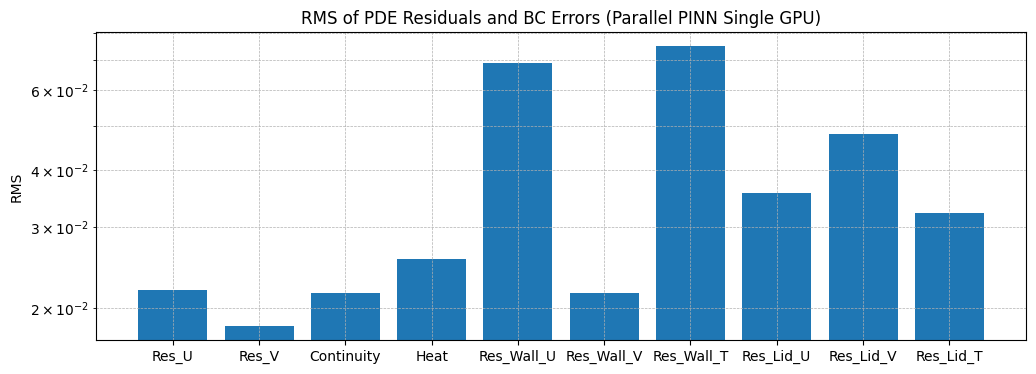

In [35]:
# Plotting Residuals RMS Values

res_u_rms,res_v_rms,res_c_rms,res_T_rms,res_wall_u_rms,res_wall_v_rms,res_wall_T_rms,res_lid_u_rms,res_lid_v_rms,res_lid_T_rms = compute_res_rms()

labels = ['Res_U','Res_V','Continuity','Heat','Res_Wall_U','Res_Wall_V','Res_Wall_T','Res_Lid_U','Res_Lid_V','Res_Lid_T']
values = [res_u_rms,res_v_rms,res_c_rms,res_T_rms,res_wall_u_rms,res_wall_v_rms,res_wall_T_rms,res_lid_u_rms,res_lid_v_rms,res_lid_T_rms]

plt.figure(figsize = (12,4))
plt.bar(labels,values)
plt.yscale('log')
plt.ylabel("RMS")
plt.title('RMS of PDE Residuals and BC Errors (Parallel PINN Single GPU)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

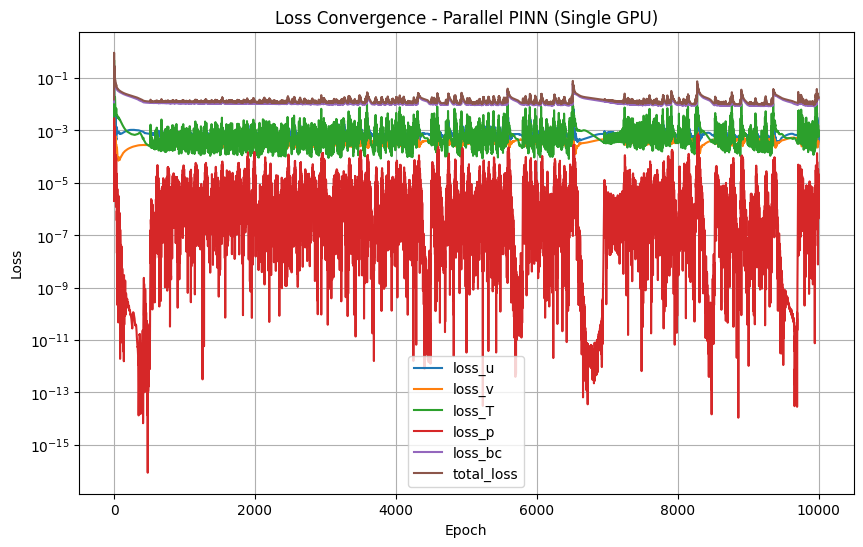

In [40]:
plt.figure(figsize=(10,6))
plt.plot(loss_u_list, label='loss_u')
plt.plot(loss_v_list, label='loss_v')
plt.plot(loss_T_list, label='loss_T')
plt.plot(loss_p_list, label='loss_p')
plt.plot(loss_bc_list, label='loss_bc')
plt.plot(total_loss_list, label='total_loss')
plt.yscale('log'); plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Loss Convergence - Parallel PINN (Single GPU)'); plt.legend(); plt.grid(True)
plt.show()

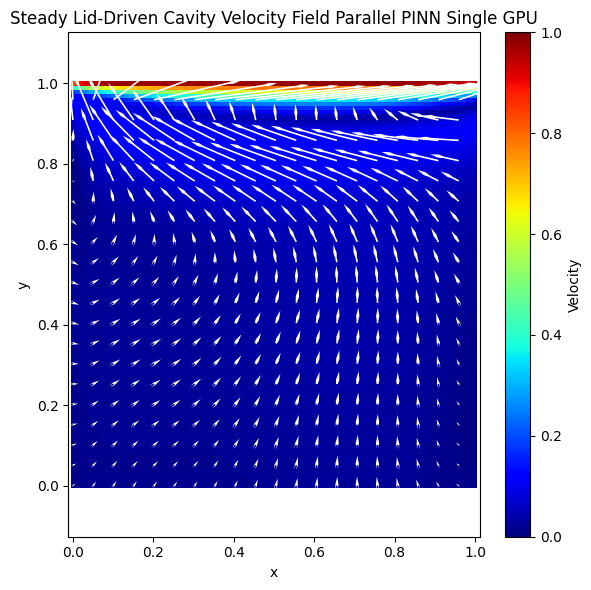

In [41]:
# Visualization

x = np.linspace(0,1,100)   # 100 X 1
y = np.linspace(0,1,100)   # 100 X 1

X,Y = np.meshgrid(x,y)     # Both 100 X 100

XY = np.stack([X.ravel(),Y.ravel()], axis = 1)   # 10000 X 2

net_u.eval()
net_v.eval()

with torch.no_grad():
    inp = torch.tensor(XY, dtype = torch.float32, device = device)
   
    
    u_pred = net_u(inp).cpu().numpy()    # 10000 X 1
    v_pred = net_v(inp).cpu().numpy()    # 10000 X 1
    p_pred = net_p(inp).cpu().numpy()    # 10000 X 1
    T_pred = net_T(inp).cpu().numpy()    # 10000 X 1

U = u_pred.reshape(100,100)  # 100 X 100
V = v_pred.reshape(100,100)  # 100 X 100

speed = np.sqrt(U**2 + V**2)


plt.figure(figsize = (6,6))
pc = plt.pcolormesh(X,Y,speed, cmap = 'jet', shading = 'auto', vmin = 0, vmax = 1)
plt.colorbar(pc, label = 'Velocity')

dx = slice(None, None, 5)
dy = slice(None, None, 5)

plt.quiver(X[dx,dy], Y[dx,dy], U[dx,dy], V[dx,dy], color='white', scale_units='xy', scale=1,
    width=0.004, headwidth=2, headlength=5, headaxislength=8, minlength=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Steady Lid-Driven Cavity Velocity Field Parallel PINN Single GPU')
plt.axis('equal')
plt.tight_layout()
plt.show()


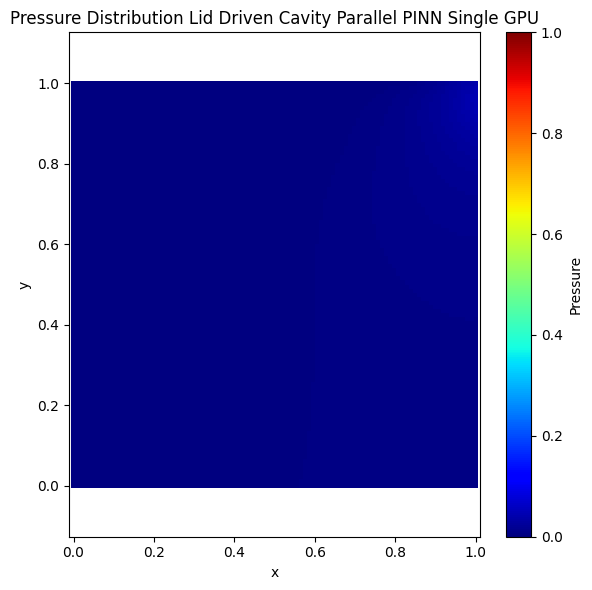

In [42]:
P = p_pred.reshape(100,100)       # 100 X 100


plt.figure(figsize = (6,6))
pc = plt.pcolormesh(X,Y,P, cmap = 'jet', shading = 'auto', vmin = 0, vmax = 1)
plt.colorbar(pc, label = 'Pressure')


plt.xlabel('x')
plt.ylabel('y')
plt.title('Pressure Distribution Lid Driven Cavity Parallel PINN Single GPU')
plt.axis('equal')
plt.tight_layout()
plt.show()

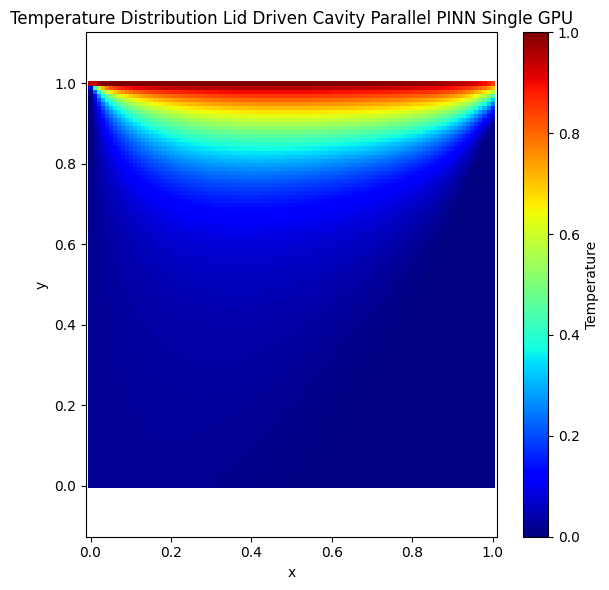

In [44]:
T = T_pred.reshape(100,100)       # 100 X 100


plt.figure(figsize = (6,6))
pc = plt.pcolormesh(X,Y,T, cmap = 'jet', shading = 'auto', vmin = 0, vmax = 1)
plt.colorbar(pc, label = 'Temperature')


plt.xlabel('x')
plt.ylabel('y')
plt.title('Temperature Distribution Lid Driven Cavity Parallel PINN Single GPU')
plt.axis('equal')
plt.tight_layout()
plt.show()